In [ ]:
! pip install transformers datasets
! pip install accelerate -U
! pip install transformers[torch]
! pip install evaluate

In [6]:
from datasets import load_dataset, DatasetDict

ds = load_dataset("csv", data_files="weibo_senti_100k.csv")

train_testvalid = ds['train'].train_test_split(test_size=0.2)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})


In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-chinese")


def tokenize_function(examples):
    return tokenizer(examples["review"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/95990 [00:00<?, ? examples/s]

Map:   0%|          | 0/11999 [00:00<?, ? examples/s]

Map:   0%|          | 0/11999 [00:00<?, ? examples/s]

In [8]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(10000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(10000))

In [ ]:
tokenized_datasets["train"][100]

<a id='trainer'></a>

In [10]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-chinese", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer_chinese")

In [12]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [13]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [14]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer_chinese", evaluation_strategy="epoch")

In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

/home/joshhu/miniconda3/envs/galore/lib/python3.11/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.116200,0.090358,0.982000
2,0.083700,0.089050,0.982100
3,0.083300,0.087150,0.982300


TrainOutput(global_step=3750, training_loss=0.09584317016601562, metrics={'train_runtime': 940.9804, 'train_samples_per_second': 31.882, 'train_steps_per_second': 3.985, 'total_flos': 7893331660800000.0, 'train_loss': 0.09584317016601562, 'epoch': 3.0})

In [ ]:
from transformers import pipeline
pipe = pipeline("sentiment-analysis", model='test_trainer_chinese/checkpoint-3500', tokenizer=tokenizer)

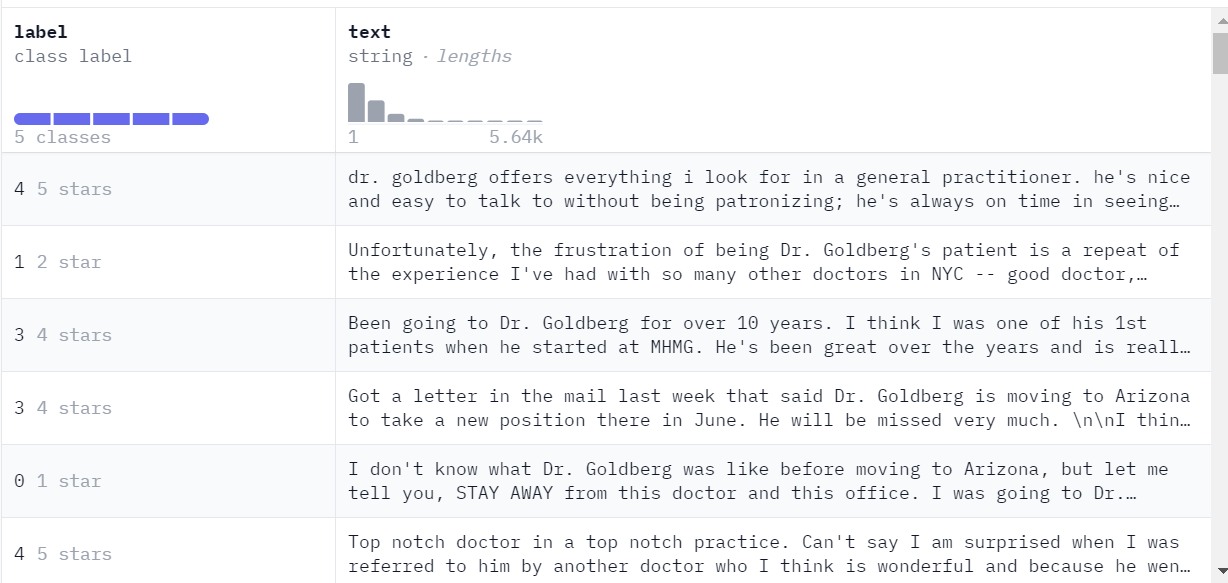

In [ ]:
pipe("will go again")

## 用PyTorch來訓練

<a id='pytorch_native'></a>

In [ ]:
import torch
del model
del trainer
torch.cuda.empty_cache()

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

In [ ]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(10000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(10000))

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

In [ ]:
import evaluate

metric = evaluate.load("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

<a id='additional-resources'></a>